### LITTLE EYES V6
#### Meu Sexto Modelo de Visão Computacional
Validação cruzada / controle de parada para selecionar o modelo mais genérico


In [31]:
# NETWORK
the_seed = 32
digit_size = (28, 28, 1)
convnn_acivation = 'relu'
fully_connected_acivation = 'tanh'
hyperparameter_max = 5
phi_step, max_phi = 5, 15
learning_rate = 0.001
patience = 25
max_epochs = 5 * patience
score_metric = 'accuracy'
verbose = 1
batch_size = None

# VALIDATION
n_folds = 3

# TRAINING PARAMETERS
use_k_fold = False
capacity = 4
jitter = 0
validation_proportion = 0.20

In [51]:
import tensorflow
from tensorflow.keras import datasets, layers, models, optimizers, Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot
import numpy
import pandas
import random
from sklearn.model_selection import StratifiedKFold, train_test_split
from seaborn import boxplot
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix

In [33]:
random.seed(the_seed)
numpy.random.seed(the_seed)
tensorflow.random.set_seed(the_seed)

In [34]:
def create_little_eyes(digit_size : tuple[int, int, int] = (28, 28, 1),
                      convnn_acivation : str = 'relu',
                      fully_connected_acivation : str = 'tanh',
                      net_name : str = 'LittleEyes',
                      hyperparameter : int = 1,
                      phi : float = 0):
        # CAMADA OCULTA
    inputs = Input(shape=digit_size)
    
    # CAMADA DE AUMENTO DE DADOS
    rotator = layers.RandomRotation(phi)
    x = rotator(inputs)

    # PRIMEIRA CAMADA CONVOLUCIONAL
    conv_2d_layer_1 = layers.Conv2D(2 * hyperparameter, (3, 3), activation = convnn_acivation)
    x = conv_2d_layer_1(x)

    # PRIMEIRA CAMADA MAX POOLING
    maxpool_1 = layers.MaxPooling2D((2, 2))
    x = maxpool_1(x)

    # SEGUNDA CAMADA CONVOLUCIONAL
    conv_2d_layer_2 = layers.Conv2D(4 * hyperparameter, (3, 3), activation = convnn_acivation)
    x = conv_2d_layer_2(x)

    # SEGUNDA CAMADA MAX POOLING
    maxpool_2 = layers.MaxPooling2D((2, 2))
    x = maxpool_2(x)

    # TERCEIRA CAMADA CONVOLUCIONAL
    conv_2d_layer_3 = layers.Conv2D(4 * hyperparameter, (3, 3), activation = convnn_acivation)
    x = conv_2d_layer_3(x)

    # TERCEIRA CAMADA MAX POOLING
    maxpool_3 = layers.MaxPooling2D((2, 2))
    x = maxpool_3(x)

    # FLATTEN
    flatten_layer = layers.Flatten()
    x = flatten_layer(x)

    # FULLY CONNECTED HIDDEN LAYER
    hidden_layer = layers.Dense(hyperparameter + 1, activation = fully_connected_acivation)
    x = hidden_layer(x)

    # OUTPUT LAYER
    output_layer = layers.Dense(10)
    outputs = output_layer(x)

    return Model(inputs = inputs, outputs = outputs, name = net_name)

In [35]:
(train_images, train_labels), (validation_images, validation_labels) = datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, validation_images = train_images / 255.0, validation_images / 255.0

In [36]:
result_list = []
kfolder = StratifiedKFold(n_splits=n_folds, random_state=the_seed, shuffle=True)
early_stopping = EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True, verbose=verbose)
opt = optimizers.Adam(learning_rate=learning_rate)
print(f"Training started...")

if use_k_fold:
    for hyperparameter in numpy.arange(1, hyperparameter_max+1):
        for phi in numpy.arange(0, max_phi+phi_step, phi_step):
            for i, (train_index, validation_index) in enumerate(kfolder.split(train_images, train_labels)):
                X_train, Y_train = train_images[train_index], train_labels[train_index]
                X_val, Y_val = train_images[validation_index], train_labels[validation_index]

                # NET NAME > Hyperparameter + Fold Number
                net_name = f"0_0_{hyperparameter}-{phi}_{i}"

                little_eyes = create_little_eyes(net_name = net_name,
                                                hyperparameter=hyperparameter,
                                                phi=phi)

                little_eyes.compile(optimizer=opt,
                            loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=[score_metric])

                history = little_eyes.fit(X_train, Y_train, epochs=max_epochs, 
                                        validation_data=(X_val, Y_val),
                                        verbose=verbose,
                                        batch_size=batch_size,
                                        callbacks=[early_stopping])

                training_score = history.history[score_metric][-1]
                validation_score = history.history[f"val_{score_metric}"][-1]
                result_list.append((net_name, hyperparameter, phi, i, training_score, validation_score, little_eyes, history))
                print(f"{net_name.upper()}: {100*training_score:.0f}% TRAINING {score_metric.upper()} / {100*validation_score:.0f}% VALIDATION {score_metric.upper()}")
else:
    # NET NAME > Hyperparameter + Fold Number
    net_name = f"0_0_{capacity}-{jitter}"
    X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, 
                                                      test_size=validation_proportion, random_state=the_seed)
    little_eyes = create_little_eyes(net_name=net_name,
                                    hyperparameter=capacity,
                                    phi=jitter)

    little_eyes.compile(optimizer=opt,
                        loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=[score_metric])

    history = little_eyes.fit(X_train, Y_train, epochs=max_epochs, 
                            validation_data=(X_val, Y_val),
                            verbose=verbose,
                            batch_size=batch_size,
                            callbacks=[early_stopping])

    training_score = history.history[score_metric][-1]
    validation_score = history.history[f"val_{score_metric}"][-1]
    print(f"{net_name.upper()}: {100*training_score:.0f}% TRAINING {score_metric.upper()} / {100*validation_score:.0f}% VALIDATION {score_metric.upper()}")

Training started...
Epoch 1/125
1500/1500 [==============================] - 15s 9ms/step - loss: 0.8132 - accuracy: 0.8010 - val_loss: 0.3776 - val_accuracy: 0.9163
Epoch 2/125
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2743 - accuracy: 0.9367 - val_loss: 0.2383 - val_accuracy: 0.9405
Epoch 3/125
1500/1500 [==============================] - 14s 9ms/step - loss: 0.1868 - accuracy: 0.9522 - val_loss: 0.1756 - val_accuracy: 0.9538
Epoch 4/125
1500/1500 [==============================] - 13s 9ms/step - loss: 0.1515 - accuracy: 0.9604 - val_loss: 0.1571 - val_accuracy: 0.9596
Epoch 5/125
1500/1500 [==============================] - 13s 9ms/step - loss: 0.1287 - accuracy: 0.9649 - val_loss: 0.1355 - val_accuracy: 0.9638
Epoch 6/125
1500/1500 [==============================] - 13s 9ms/step - loss: 0.1149 - accuracy: 0.9695 - val_loss: 0.1276 - val_accuracy: 0.9649
Epoch 7/125
1500/1500 [==============================] - 13s 9ms/step - loss: 0.1049 - accuracy: 0.9715 

In [37]:
if use_k_fold:
    results = pandas.DataFrame.from_records(result_list)
    results.columns = ["net_name", 'hyperparameter', "phi", "kfold", score_metric, f"val_{score_metric}", "little_eyes", "history"]
    results.sort_values("val_accuracy", ascending = False)

In [38]:
if use_k_fold:
    fig = pyplot.figure(figsize = (8, 4.5))
    ax = fig.add_subplot(111)
    boxplot(results, x = 'hyperparameter', y = 'accuracy', ax = ax)
    ax.grid()

In [39]:
if use_k_fold:
    little_eyes = results.sort_values("val_accuracy", ascending = False).head(1)['little_eyes'].values[0]
    little_eyes_history = results.sort_values("val_accuracy", ascending = False).head(1)['history'].values[0]
else: 
    little_eyes_history = history

In [45]:
best_epoch = len(little_eyes_history.history['loss'][:-patience - 1])
best_val_loss = little_eyes_history.history['val_loss'][-patience - 1]
best_val_metric = little_eyes_history.history[f'val_{score_metric}'][-patience - 1]

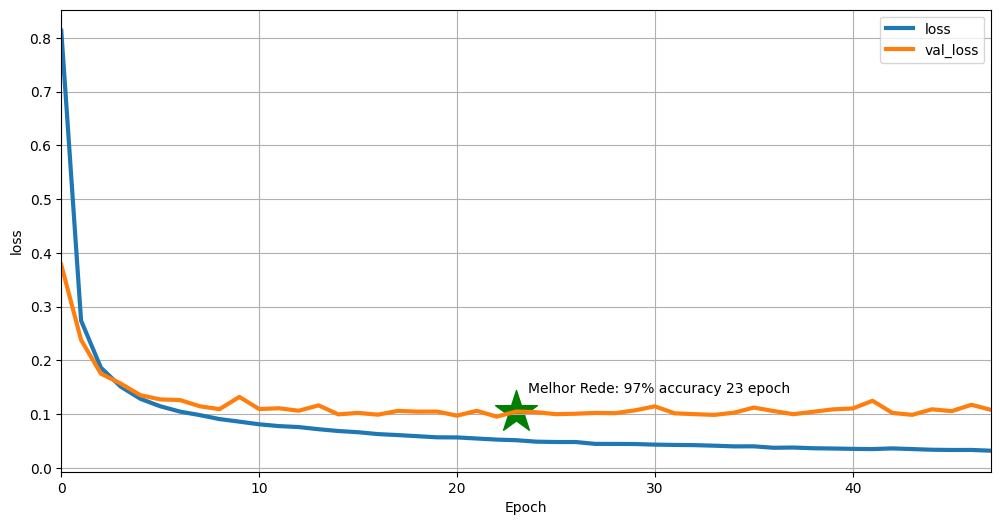

In [54]:
fig = pyplot.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
_ = ax.plot(little_eyes_history.history['loss'], label='loss', linewidth=3)
_ = ax.plot(little_eyes_history.history['val_loss'], label = 'val_loss', linewidth=3)
_ = ax.scatter(x=[best_epoch], y=[best_val_loss], marker='*', s=1000, color='green')
_ = ax.grid(which='both')
_ = ax.set_xlim([0, 47])
_ = pyplot.xlabel('Epoch')
_ = pyplot.ylabel('loss')
_ = ax.legend(loc='upper right')
_ = ax.annotate(f'Melhor Rede: {100.0*best_val_metric:.0f}% {score_metric.lower()} {best_epoch} epoch',
                (best_epoch, best_val_loss),
                (1.025*best_epoch, 1.33*best_val_loss))

In [41]:
Y_test = little_eyes.predict(validation_images)

313/313 [==============================] - 1s 3ms/step


In [42]:
Y_predicted = numpy.argmax(Y_test, axis = 1)
Y_predicted

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

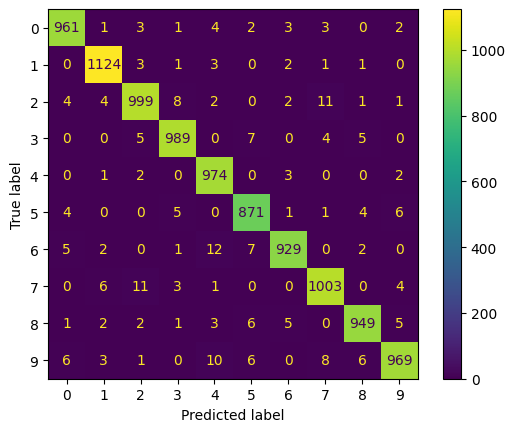

In [52]:
ConfusionMatrixDisplay.from_predictions(validation_labels, Y_predicted)

In [71]:
prediction_list  = []
for y_true, y_pred in zip(validation_labels, Y_predicted):
    prediction_list.append((y_true, y_pred))
    
df_pred = pandas.DataFrame.from_records(prediction_list, columns = ['y_true', 'y_pred'])

ix_true = df_pred.y_true == 9
ix_pred = df_pred.y_pred == 6

df_pred.loc[ix_true & ix_pred, :]

,y_true,y_pred


TRUE NUMBER: 8 >> PREDICTED NUMBER: 1


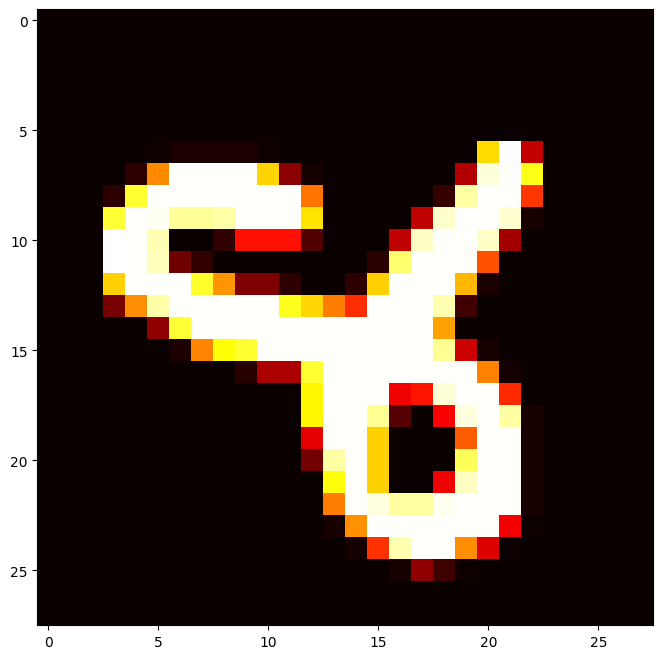

In [69]:
# TABAJARA VALIDATOR
image_id = 4601
print(f"TRUE NUMBER: {validation_labels[image_id]} >> PREDICTED NUMBER: {Y_predicted[image_id]}")
# Y_test[image_id, :]
fig = pyplot.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
_ = pyplot.imshow(validation_images[image_id], cmap='hot')

In [44]:
accuracy_score(validation_labels, Y_predicted)

0.9768